### Project 2
### Name Tao Jiang (Tommy)
### Student ID: 20004769

# NBA Player Salary Exploratory Data Analysis

## Abstract
### As we all know, some NBA star players have very high salaries. This report investigates which factors that influence the salary for basketball players in the NBA. The data consists of performance measures and salaries from season 2019-2020 from  basketball-reference.com and  espn.com. The two parts of data sources come from authoritative and trustworthy websites.


### *Research Question*: 
> ### The player position has some relevance with salary or not.

> ### Discover which statistics are the best effect of an NBA player’s salary.

> ### Look for linear and non-linear associations between the salary and performance of players.

> ### Use a machine learning model to predict NBA salaries.


## Summary 

###  Most of the players get a salary of under ten million in fact, and position has less relevance with salary. For high-quality players, the number of Point Guards(PG) is higher than the others. Moreover,  it is hard to measure the salary of a player by a single performance index. The study was performed by using regression and classifier machine learning methods for parts of features.  The SVM model has higher accuracy(70%). However, All of the regression models have poor fitting effects. Improving accuracy depends on more data and model tuning, which needs to be optimized more carefully later.


* ## Loading the data and analysis libraries

> ### Loading libraries

In [220]:
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.pyplot import GridSpec
import numpy as np
import pandas as pd
import os, sys
import seaborn as sns
sns.set(style="ticks")
from pylab import rcParams
rcParams['figure.figsize'] = (7,5)
rcParams['figure.dpi'] = 120
rcParams['savefig.dpi'] = 120 
rcParams['font.size'] = 20
rcParams['axes.facecolor'] = 'white'
matplotlib.style.use('ggplot')
import statsmodels.formula.api as smf
import statsmodels.api as sm
import missingno as msno
import sklearn
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

> ### loading player stats data

In [221]:
players = pd.read_csv("stats.csv.gz",index_col=0)
print(players.shape)
players.head()

(649, 29)


,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,Steven Adams,C,26.0,OKC,58.0,58.0,1564.0,262.0,443.0,0.591,...,0.590,196.0,347.0,543.0,141.0,50.0,65.0,86.0,111.0,633.0
1,Bam Adebayo,PF,22.0,MIA,65.0,65.0,2235.0,408.0,719.0,0.567,...,0.690,165.0,518.0,683.0,333.0,78.0,85.0,185.0,164.0,1053.0
2,LaMarcus Aldridge,C,34.0,SAS,53.0,53.0,1754.0,391.0,793.0,0.493,...,0.827,103.0,289.0,392.0,129.0,36.0,87.0,74.0,128.0,1001.0
3,Nickeil Alexander-Walker,SG,21.0,NOP,41.0,0.0,501.0,77.0,227.0,0.339,...,0.607,8.0,72.0,80.0,74.0,11.0,7.0,40.0,46.0,211.0
4,Grayson Allen,SG,24.0,MEM,30.0,0.0,498.0,79.0,176.0,0.449,...,0.857,5.0,61.0,66.0,43.0,6.0,1.0,23.0,36.0,221.0


> ### Loading salary data

In [222]:
raw_salary = pd.read_csv("salary.csv.gz",index_col=0)
print(raw_salary.shape)
raw_salary.head()

(564, 4)


,RK,NAME,TEAM,SALARY
0,1,"Stephen Curry, PG",Golden State Warriors,"$40,231,758"
1,2,"Chris Paul, PG",Oklahoma City Thunder,"$38,506,482"
2,3,"Russell Westbrook, PG",Houston Rockets,"$38,506,482"
3,4,"John Wall, PG",Washington Wizards,"$38,199,000"
4,5,"Kevin Durant, SF",Brooklyn Nets,"$38,199,000"


> ### I need the player's name and salary for this report only. The salary format needs change to standard numbers.

In [223]:
player_name_pos = raw_salary['NAME'].str
player_name_pos = player_name_pos.split(',', 1)
raw_salary['full-name'] = player_name_pos.str[0]

In [224]:
to_str =[]
for i in raw_salary['SALARY']:
    if i != 0:
        to_str.append( i.replace("$","").replace(",",""))

raw_salary['SALARY'] = pd.to_numeric(to_str, errors='coerce')
salary = raw_salary[['full-name','SALARY']]
salary = salary.rename(columns={'full-name':'Player','SALARY':'Salary'})


In [225]:
print(salary.shape)
salary.head()

(564, 2)


,Player,Salary
0,Stephen Curry,40231758.0
1,Chris Paul,38506482.0
2,Russell Westbrook,38506482.0
3,John Wall,38199000.0
4,Kevin Durant,38199000.0


>### Change the unit of measure to million.

In [226]:
salary['Salary(million)'] = salary['Salary']/1000000
salary.head()

,Player,Salary,Salary(million)
0,Stephen Curry,40231758.0,40.231758
1,Chris Paul,38506482.0,38.506482
2,Russell Westbrook,38506482.0,38.506482
3,John Wall,38199000.0,38.199000
4,Kevin Durant,38199000.0,38.199000


* ## Data merge processing
> ### Merge and concatenate the salary and the player datasets.

In [227]:
df = pd.merge(salary,players,on="Player",how='outer')
print(df.shape)
df.head()

(807, 31)


,Player,Salary,Salary(million),Pos,Age,Tm,G,GS,MP,FG,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,Stephen Curry,40231758.0,40.231758,PG,31.0,GSW,5.0,5.0,139.0,33.0,...,1.000,4.0,22.0,26.0,33.0,5.0,2.0,16.0,11.0,104.0
1,Chris Paul,38506482.0,38.506482,PG,34.0,OKC,63.0,63.0,2003.0,394.0,...,0.900,21.0,289.0,310.0,426.0,98.0,9.0,137.0,139.0,1114.0
2,Russell Westbrook,38506482.0,38.506482,PG,31.0,HOU,53.0,53.0,1905.0,568.0,...,0.777,94.0,332.0,426.0,370.0,88.0,17.0,236.0,187.0,1456.0
3,John Wall,38199000.0,38.199000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Kevin Durant,38199000.0,38.199000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [228]:
df.columns

Index(['Player', 'Salary', 'Salary(million)', 'Pos', 'Age', 'Tm', 'G', 'GS',
       'MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%',
       'eFG%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK',
       'TOV', 'PF', 'PTS'],
      dtype='object')

> ### Dataset structure reorganization


In [229]:
merge_data = df.groupby('Player').agg({col:'max' for col in df.columns})
merge_data = merge_data.drop(['Player','Salary'], axis=1)
merge_data = merge_data.loc[:, ~merge_data.columns.str.contains('^Unnamed')]
merge_data = merge_data.rename(
    columns={ 'Salary(million)':'Salary','3P':'P3','3P%':'P3%','2P':'P2','2P%':'P2%','2PA':'P2A'})
# merge_data.columns

> ### We got a 634 column records and 29 features dataset.

In [230]:
print(merge_data.shape)
merge_data.head()

(634, 29)


,Salary,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
Player,,,,,,,,,,,,,,,,,,,,,
Aaron Gordon,19.863636,PF,24.0,ORL,58.0,58.0,1914.0,314.0,726.0,0.433,...,0.675,103.0,338.0,441.0,215.0,50.0,36.0,94.0,116.0,833.0
Aaron Holiday,2.329200,PG,23.0,IND,58.0,26.0,1368.0,202.0,496.0,0.407,...,0.861,21.0,111.0,132.0,193.0,45.0,13.0,75.0,102.0,546.0
Aaron Jackson,1.378242,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Abdel Nader,1.618520,SF,26.0,OKC,48.0,5.0,756.0,100.0,220.0,0.455,...,0.774,14.0,76.0,90.0,35.0,20.0,20.0,36.0,65.0,287.0
Adam Mokoka,NaN,SG,21.0,CHI,11.0,0.0,112.0,12.0,28.0,0.429,...,0.500,7.0,3.0,10.0,4.0,4.0,0.0,2.0,17.0,32.0


### Dataset persistence

In [231]:
merge_data.to_csv("raw_players_salary.csv.gz", compression='gzip')

* ## Missing value processing

In [232]:
raw_players_salary = pd.read_csv("raw_players_salary.csv.gz")

> ### The chart shows the missing value distribution. The reason for the plentiful number of missing values is that the data come from different Statistical agencies. 

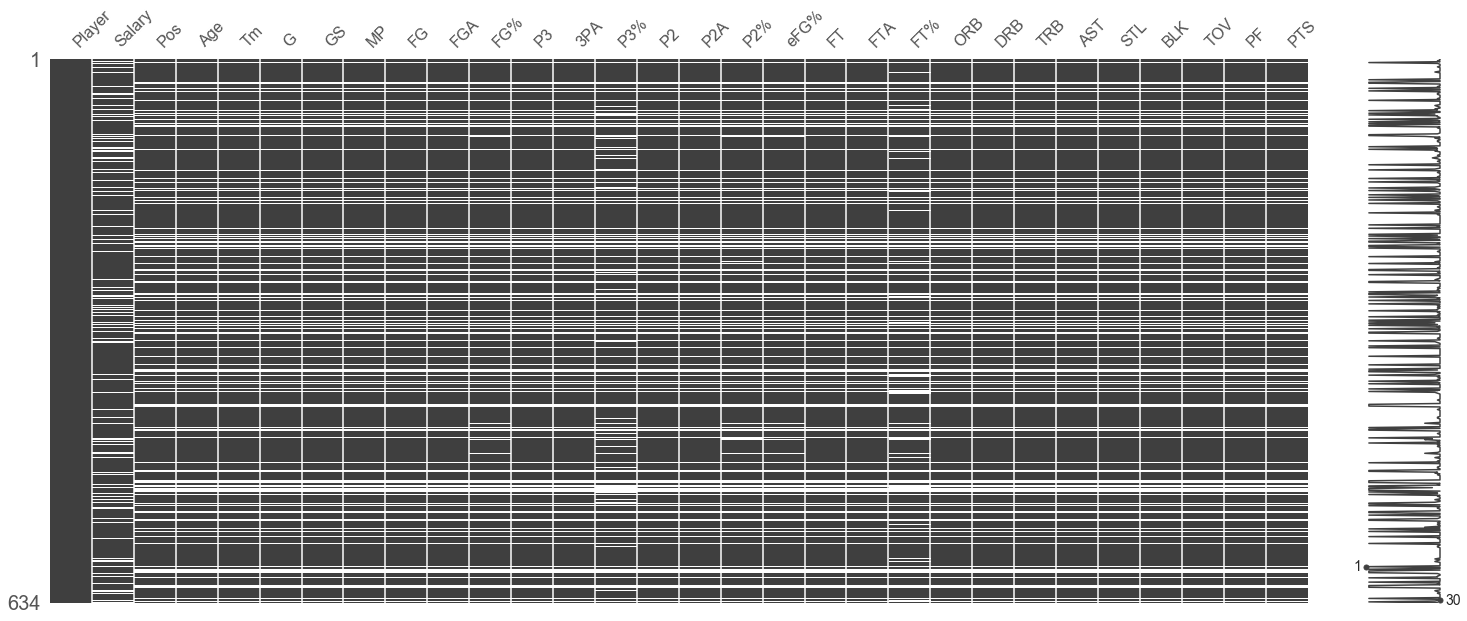

In [233]:
msno.matrix(raw_players_salary.sample(raw_players_salary.shape[0]))

> ### there is some reason such as injuerd, part of palyers dont have stats. but the league still give a value for them.

In [235]:
raw_players_salary["Salary"].isnull
miss_stat_palyers = raw_players_salary[raw_players_salary["Salary"].isnull()]
miss_stat_palyers.to_csv("miss_stat_palyers.csv.gz", compression='gzip')
miss_stat_palyers

,Player,Salary,Pos,Age,Tm,G,GS,MP,FG,FGA,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
4,Adam Mokoka,NaN,SG,21.0,CHI,11.0,0.0,112.0,12.0,28.0,...,0.500,7.0,3.0,10.0,4.0,4.0,0.0,2.0,17.0,32.0
10,Alen Smailagić,NaN,PF,19.0,GSW,14.0,0.0,139.0,20.0,40.0,...,0.842,10.0,17.0,27.0,13.0,3.0,4.0,11.0,14.0,59.0
20,Amir Coffey,NaN,SG,22.0,LAC,13.0,0.0,98.0,13.0,33.0,...,0.333,4.0,10.0,14.0,9.0,1.0,1.0,3.0,12.0,28.0
27,Ante Žižić,NaN,C,23.0,CLE,22.0,0.0,221.0,41.0,72.0,...,0.737,18.0,48.0,66.0,6.0,7.0,5.0,10.0,27.0,96.0
31,Antonius Cleveland,NaN,SG,25.0,DAL,6.0,0.0,22.0,2.0,6.0,...,0.500,0.0,3.0,3.0,0.0,1.0,1.0,1.0,2.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
618,William Howard,NaN,SG,26.0,HOU,2.0,0.0,13.0,0.0,4.0,...,NaN,0.0,2.0,2.0,1.0,0.0,0.0,1.0,1.0,0.0
621,Willy Hernangómez,NaN,C,25.0,CHO,31.0,0.0,375.0,74.0,139.0,...,0.627,43.0,91.0,134.0,29.0,10.0,7.0,30.0,32.0,190.0
625,Yuta Watanabe,NaN,SG,25.0,MEM,16.0,0.0,99.0,12.0,29.0,...,0.375,6.0,11.0,17.0,4.0,5.0,1.0,2.0,9.0,30.0
628,Zach Norvell,NaN,SG,22.0,TOT,5.0,0.0,41.0,3.0,12.0,...,1.000,0.0,6.0,6.0,3.0,2.0,0.0,3.0,4.0,10.0


> ### In order to get a reliable dataset and an accuracy model, we could use the player of previous performance data to fill it.
I find a Api could get previous seson stats date for them.

In [205]:
len(miss_stat_palyers)
# miss_stat_palyers["Player"]

120

In [206]:
import requests
import json


In [207]:
miss_stat_palyers['firstName'] =  miss_stat_palyers["Player"].str.split(" ",1).str[0]
miss_stat_palyers['lastName'] =  miss_stat_palyers["Player"].str.split(" ",1).str[1]
miss_stat_palyers.head()

,Player,Salary,Pos,Age,Tm,G,GS,MP,FG,FGA,...,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,firstName,lastName
2,Aaron Jackson,1.378242,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Aaron,Jackson
9,Alen Smailagic,0.898310,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Alen,Smailagic
11,Alex Abrines,5.455236,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Alex,Abrines
14,Alexis Ajinca,5.285394,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Alexis,Ajinca
23,Andre Roberson,10.740740,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Andre,Roberson


In [171]:
miss_stat_palyers.iterrows()

<generator object DataFrame.iterrows at 0x1c36db78d0>

In [159]:
url = 'https://nba-players.herokuapp.com/players-stats/%s/%s'% ('Aaron','Jackson')
url

'https://nba-players.herokuapp.com/players-stats/Aaron/Jackson'

In [212]:
record = []
for index, row in miss_stat_palyers.iterrows():
    url = 'https://nba-players.herokuapp.com/players-stats/%s/%s'% (row['lastName'],row['firstName'])
    response = requests.request("GET", url)
    if response.text == 'Sorry, that player was not found. Please check the spelling.':
        pass
    else:
        json_data = json.loads(response.text)
        one_miss_player =   raw_players_salary[raw_players_salary['Player'] == json_data['name'] ]
        one_miss_player['Tm'] = j['team_acronym']
        one_miss_player['G'] = j['games_played']

        one_miss_player['MP'] = j['minutes_per_game'].split(':',1)[0]
        one_miss_player['FG'] = j['field_goals_attempted_per_game']
        one_miss_player['FGA'] = j['field_goals_made_per_game']
        one_miss_player['FG%'] = j['field_goal_percentage']

        one_miss_player['3P'] = j['free_throw_percentage']
        one_miss_player['3PA'] = j['three_point_attempted_per_game']
        one_miss_player['3P%'] = j['three_point_percentage']


        one_miss_player['ORB'] = j['offensive_rebounds_per_game']
        one_miss_player['DRB'] = j['defensive_rebounds_per_game']

        one_miss_player['AST'] = j['assists_per_game']
        one_miss_player['STL'] = j['steals_per_game']

        one_miss_player['BLK'] = j['blocks_per_game']
        one_miss_player['TOV'] = j['turnovers_per_game']
        one_miss_player['PTS'] = j['points_per_game']

    

In [213]:
raw_players_salary

,Player,Salary,Pos,Age,Tm,G,GS,MP,FG,FGA,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,Aaron Gordon,19.863636,PF,24.0,ORL,58.0,58.0,1914.0,314.0,726.0,...,0.675,103.0,338.0,441.0,215.0,50.0,36.0,94.0,116.0,833.0
1,Aaron Holiday,2.329200,PG,23.0,IND,58.0,26.0,1368.0,202.0,496.0,...,0.861,21.0,111.0,132.0,193.0,45.0,13.0,75.0,102.0,546.0
2,Aaron Jackson,1.378242,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Abdel Nader,1.618520,SF,26.0,OKC,48.0,5.0,756.0,100.0,220.0,...,0.774,14.0,76.0,90.0,35.0,20.0,20.0,36.0,65.0,287.0
4,Adam Mokoka,NaN,SG,21.0,CHI,11.0,0.0,112.0,12.0,28.0,...,0.500,7.0,3.0,10.0,4.0,4.0,0.0,2.0,17.0,32.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
629,Zach Randolph,11.692308,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
630,Zhaire Smith,3.058800,SG,20.0,PHI,7.0,0.0,32.0,3.0,11.0,...,0.500,0.0,2.0,2.0,2.0,3.0,0.0,2.0,4.0,8.0
631,Zhou Qi,1.378242,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
632,Zion Williamson,9.757440,PF,19.0,NOP,19.0,19.0,565.0,172.0,292.0,...,0.645,55.0,74.0,129.0,41.0,16.0,9.0,51.0,32.0,448.0


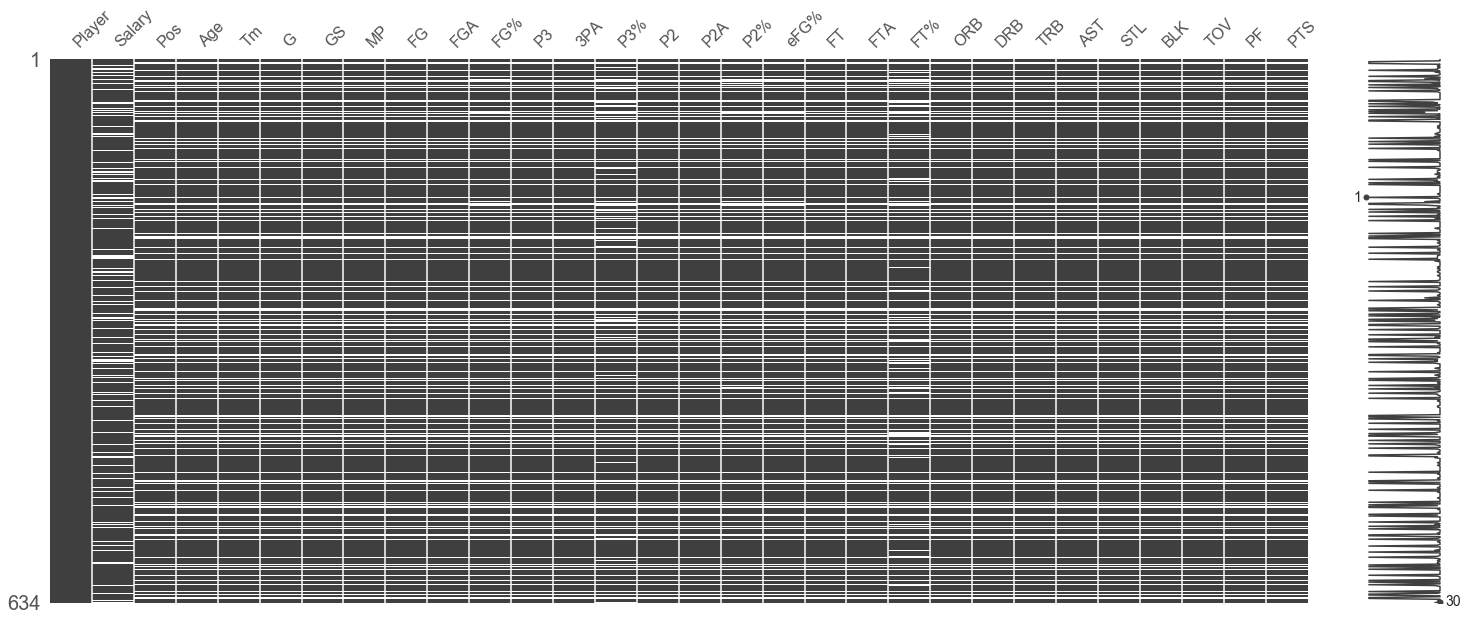

In [214]:
msno.matrix(raw_players_salary.sample(raw_players_salary.shape[0]))

In [215]:
raw_players_salary.shape

(634, 30)

In [216]:
clear_players_salary = raw_players_salary.dropna()

In [217]:
clear_players_salary.shape

(385, 30)

> ####  In order to get a reliable dataset and an accuracy model, the record that has missing value will be dropped.

In [70]:
df.groupby('Salary').agg({'Pos': lambda x: x.isnull().sum()})


,Pos
Salary,
197933.0,1
208509.0,1
350189.0,0
375385.0,0
384541.0,0
...,...
34996296.0,0
37436858.0,0
38199000.0,2


In [67]:
players_salary_na = raw_players_salary.isna()

In [68]:
players_salary_na

,Player,Salary,Pos,Age,Tm,G,GS,MP,FG,FGA,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
629,False,False,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
630,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
631,False,False,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
632,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [30]:
clear_players_salary = raw_players_salary.dropna()

In [71]:
# clear_players_salary_with_mean = raw_players_salary.fillna(df.mean())
# clear_players_salary = clear_players_salary_with_mean.fillna(0)
# msno.matrix(clear_players_salary.sample(clear_players_salary.shape[0])) 

In [31]:
print(clear_players_salary.shape)
clear_players_salary.head()

(385, 30)


,Player,Salary,Pos,Age,Tm,G,GS,MP,FG,FGA,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,Aaron Gordon,19.863636,PF,24.0,ORL,58.0,58.0,1914.0,314.0,726.0,...,0.675,103.0,338.0,441.0,215.0,50.0,36.0,94.0,116.0,833.0
1,Aaron Holiday,2.329200,PG,23.0,IND,58.0,26.0,1368.0,202.0,496.0,...,0.861,21.0,111.0,132.0,193.0,45.0,13.0,75.0,102.0,546.0
3,Abdel Nader,1.618520,SF,26.0,OKC,48.0,5.0,756.0,100.0,220.0,...,0.774,14.0,76.0,90.0,35.0,20.0,20.0,36.0,65.0,287.0
5,Admiral Schofield,1.000000,SF,22.0,WAS,27.0,2.0,293.0,30.0,75.0,...,0.692,6.0,28.0,34.0,14.0,8.0,3.0,7.0,41.0,83.0
6,Al Horford,28.000000,C,33.0,PHI,60.0,57.0,1848.0,289.0,654.0,...,0.753,92.0,320.0,412.0,244.0,52.0,55.0,65.0,128.0,722.0


>### There is no duplicate record of players in the dataset.

In [32]:
clear_players_salary['Player'].duplicated().sum() 

0

In [33]:
clear_players_salary.to_csv("clear_players_salary.csv.gz", compression='gzip')

In [34]:
clear_players_salary = pd.read_csv("clear_players_salary.csv.gz",index_col=0)

> ### The statistics table shows that mean, max, min of each feature.

In [35]:
clear_players_salary.describe()

,Salary,Age,G,GS,MP,FG,FGA,FG%,P3,3PA,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
count,385.000000,385.000000,385.000000,385.000000,385.000000,385.000000,385.000000,385.000000,385.000000,385.000000,...,385.000000,385.000000,385.000000,385.000000,385.000000,385.000000,385.000000,385.000000,385.000000,385.000000
mean,7.849734,25.836364,45.927273,22.581818,1075.231169,181.641558,397.418182,0.457429,54.659740,152.961039,...,0.763894,42.727273,150.597403,193.324675,110.389610,34.711688,21.132468,62.012987,90.392208,496.251948
std,9.024784,4.199048,16.590971,23.185600,615.731595,138.692579,295.761604,0.089461,51.079147,133.196698,...,0.129042,40.523924,110.281914,144.054030,107.104646,24.603470,23.014841,50.257435,49.734707,389.217152
min,0.350189,19.000000,2.000000,0.000000,6.000000,1.000000,3.000000,0.143000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,4.000000
25%,1.620564,22.000000,35.000000,2.000000,527.000000,74.000000,171.000000,0.410000,14.000000,43.000000,...,0.697000,16.000000,66.000000,86.000000,36.000000,14.000000,6.000000,25.000000,47.000000,191.000000
50%,3.623000,25.000000,51.000000,13.000000,1061.000000,153.000000,323.000000,0.448000,41.000000,119.000000,...,0.779000,29.000000,129.000000,162.000000,74.000000,31.000000,15.000000,49.000000,91.000000,414.000000
75%,10.259375,29.000000,59.000000,46.000000,1592.000000,259.000000,578.000000,0.489000,81.000000,222.000000,...,0.843000,57.000000,214.000000,266.000000,143.000000,51.000000,28.000000,84.000000,126.000000,692.000000
max,40.231758,43.000000,66.000000,65.000000,2243.000000,623.000000,1386.000000,1.000000,271.000000,769.000000,...,1.000000,250.000000,653.000000,869.000000,636.000000,115.000000,187.000000,289.000000,246.000000,2096.000000


> ### The bar chart shows that most of the players get a salary of under ten million.

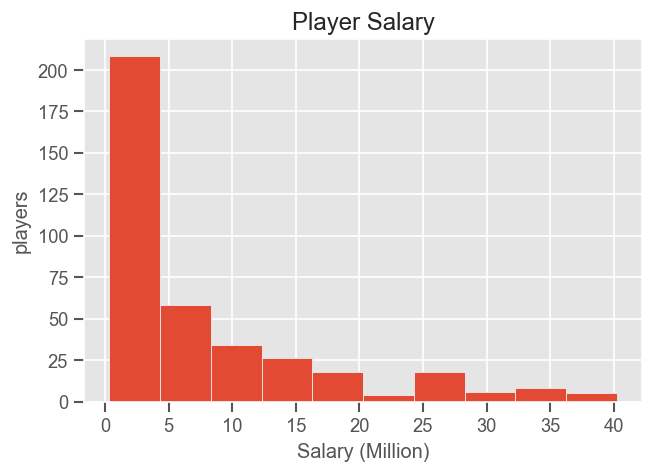

In [39]:
clear_players_salary['Salary'].hist() 
sns.utils.axlabel('Salary (Million)','players')
plt.title("Player Salary")
plt.rcParams['savefig.dpi'] = 120 
plt.rcParams['figure.dpi'] = 120 

> ### The distribution density map below further confirms that only a few star players have a salary.

/Users/Tommy/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/hist.py:316: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  ax.hist(values, bins=bins, **kwds)


Text(0.5, 1.0, 'NBA Salary Density')

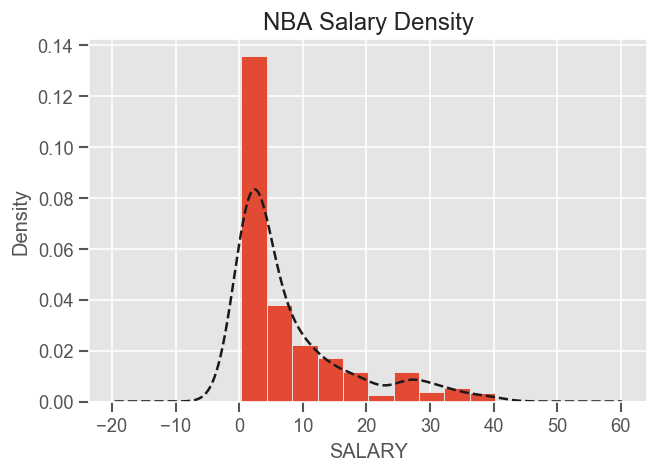

In [40]:
clear_players_salary['Salary'].hist(bins = 10,histtype = 'bar',normed =True)
clear_players_salary['Salary'].plot(kind='kde',style='k--')
plt.xlabel('SALARY') 
plt.title("NBA Salary Density")

>### We can find that the mean salary is 7.8million. However, the max of salary is over 40 million.

In [41]:
print(clear_players_salary['Salary'].mean())
clear_players_salary['Salary'].max()

7.849734155844151


40.231758

* ## positions
> ### Might the player's position correlate with the salary? 

> ### Select the top 10 players of salary.

Text(0.5, 1.0, 'TOP 10 NBA Salary')

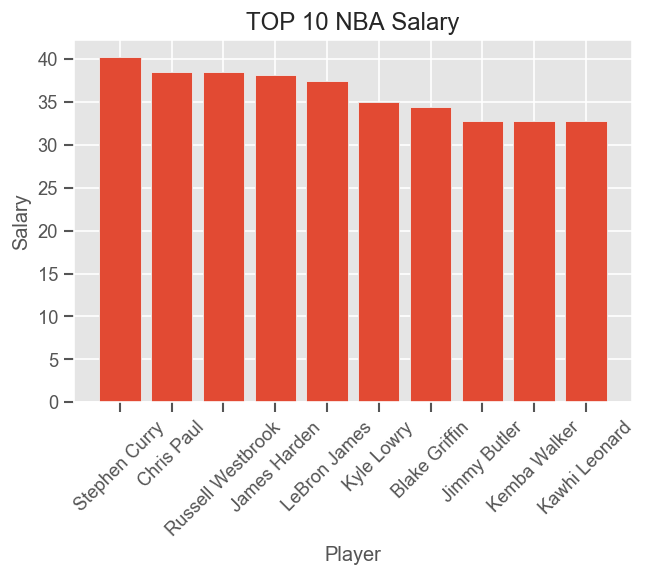

In [43]:
player_sorted=  clear_players_salary.sort_values("Salary",ascending=False)
top10 = player_sorted.head(10)
plt.bar(top10.Player,top10.Salary)
plt.ylabel("Salary")
plt.xlabel("Player" )
plt.xticks(rotation=45)
plt.title("TOP 10 NBA Salary")

> ### There are six players belong to Point Guard in the Top 10 players.

In [44]:
top10['Pos']

549    PG
87     PG
529    PG
264    SG
388    PG
378    PG
43     PF
294    SF
350    PG
344    SF
Name: Pos, dtype: object

> ### By counting the number of players in each position, we could find the Shooting Guard (SG) has the most number of players. The Swingman(SF-PF) is the least number of players, and the position requires high technology as well.

| Position | Number | 
| -- | -- | 
| SG（Shooting Guard）: |  105 | 
| PF（Power Forward）: |  77 | 
| PG（Point Guard）: |  71 | 
| SF（Small Forward）: |  68 | 
| C（Center）: |  63 | 
|SF-PF (Swingman):|     1|

In [45]:
clear_players_salary['Pos'].value_counts()

SG       105
PF        77
PG        71
SF        68
C         63
SF-PF      1
Name: Pos, dtype: int64

> ### According to visualizing the distribution of the dataset, we could get information that there is no Center(C) above the 30 million salaries, and power guards(PG) are the most. The conclusion also matches with the status quo of the NBA league, the relative demise of Centers(C).

> ### The further information form the chart is that the age of players who got above the 35 million salaries is between 30 to 35.

/Users/Tommy/opt/anaconda3/lib/python3.7/site-packages/seaborn/regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


<Figure size 1200x720 with 0 Axes>

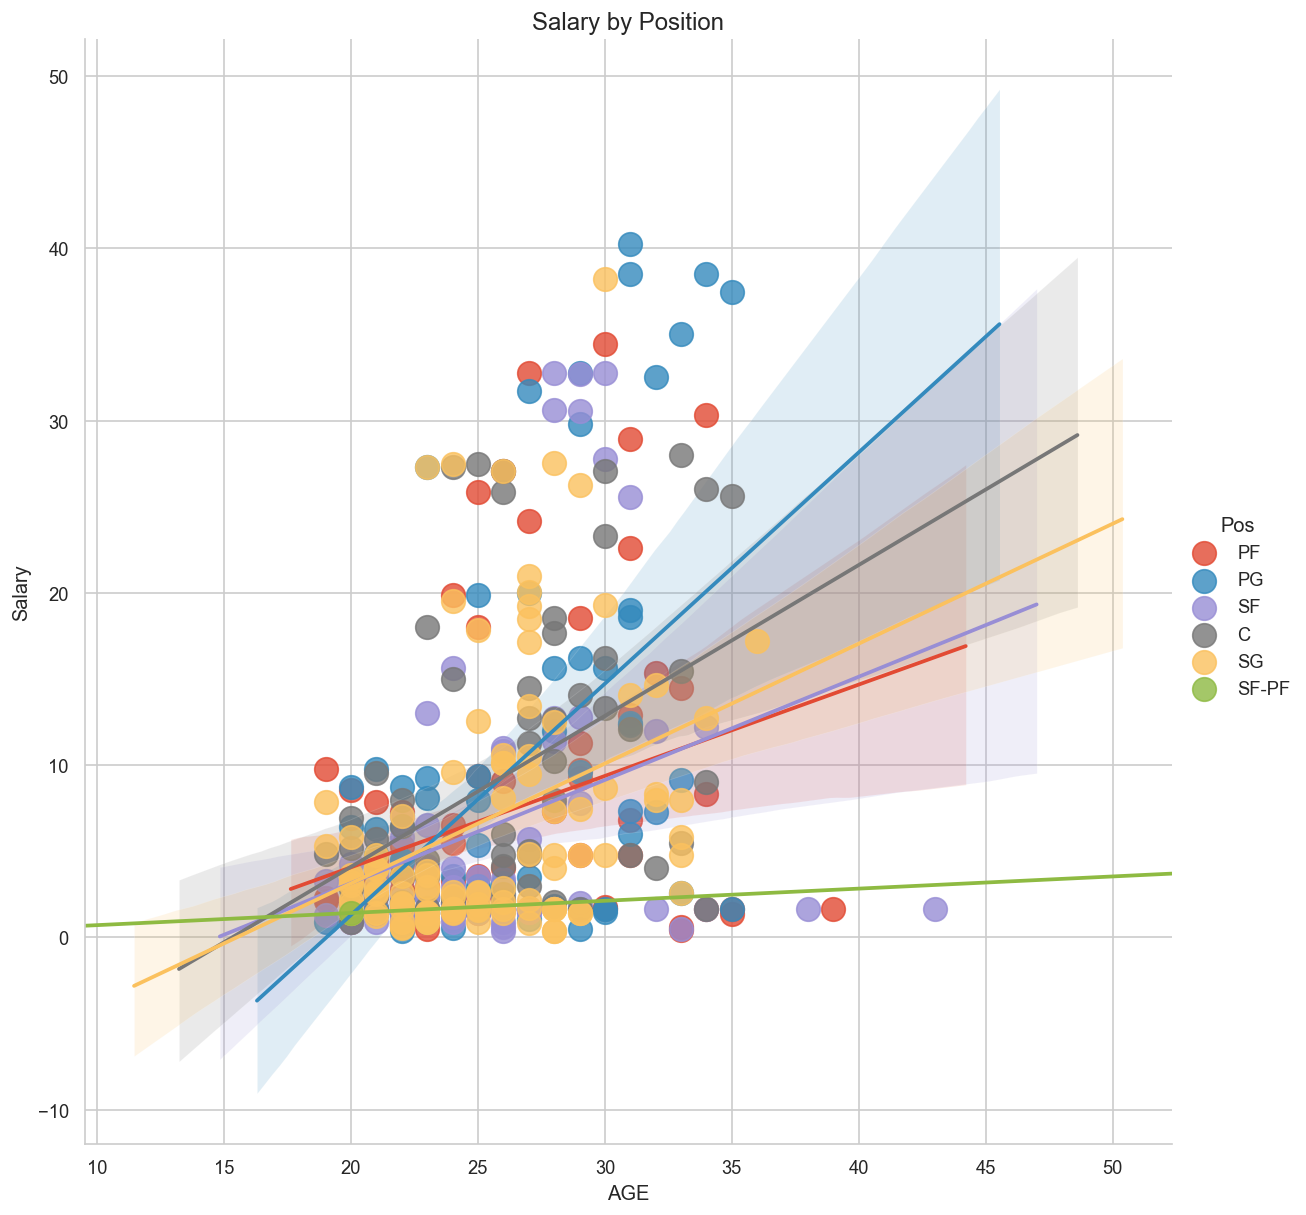

<Figure size 1200x720 with 0 Axes>

In [47]:
sns.set_style("whitegrid")
ax = sns.lmplot(x='Age', y='Salary', data=clear_players_salary, 
                hue='Pos',  aspect=1,size=10,  scatter_kws={"s": 200})
ax.set(xlabel='AGE', ylabel='Salary',title="Salary by Position")
plt.figure(figsize=(10,6))


> ### The average salary of point guards (PG) and center (C) is higher, but the salary of high-quality Point Guards(PG) is higher than the other team players. The salary of high-quality Point Guards(PG) is higher than the other team players. 

[Text(0.5, 1.0, 'Salary by Position')]

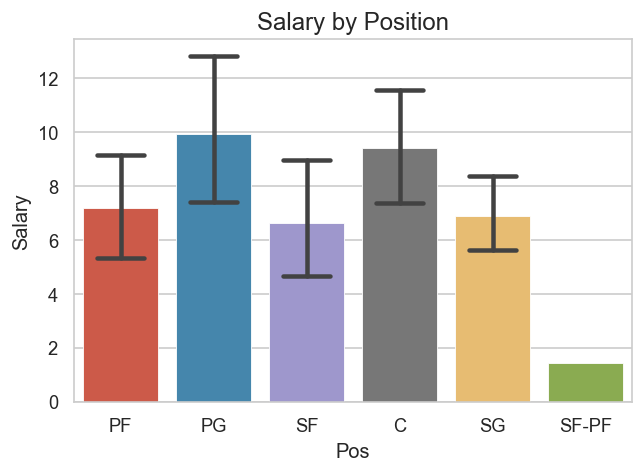

In [52]:
ax = sns.barplot(x="Pos", y="Salary",data=clear_players_salary,capsize=.5)
ax.set(title="Salary by Position")

>### The different position has the same salary distribute the result that most players get less 10 million. We can conclude that the position has a specific relationship with the salary, but it has little consequence.

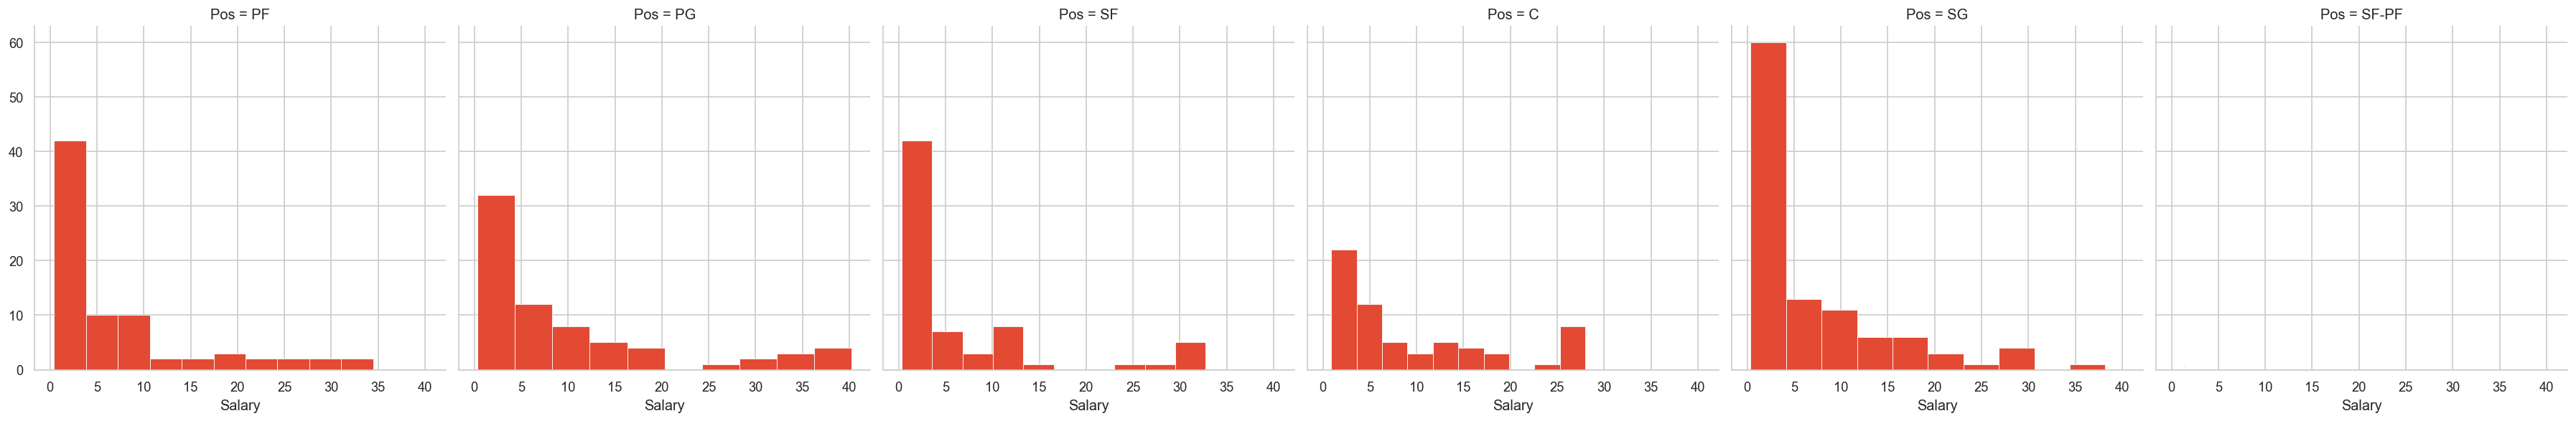

In [53]:
g = sns.FacetGrid(clear_players_salary, col="Pos", height=5)
g.map(plt.hist, "Salary")

* ## Others Feature 

> ### Correlation analysis of various Features and salary

In [54]:
clear_players_salary.columns

Index(['Player', 'Salary', 'Pos', 'Age', 'Tm', 'G', 'GS', 'MP', 'FG', 'FGA',
       'FG%', 'P3', '3PA', 'P3%', 'P2', 'P2A', 'P2%', 'eFG%', 'FT', 'FTA',
       'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS'],
      dtype='object')

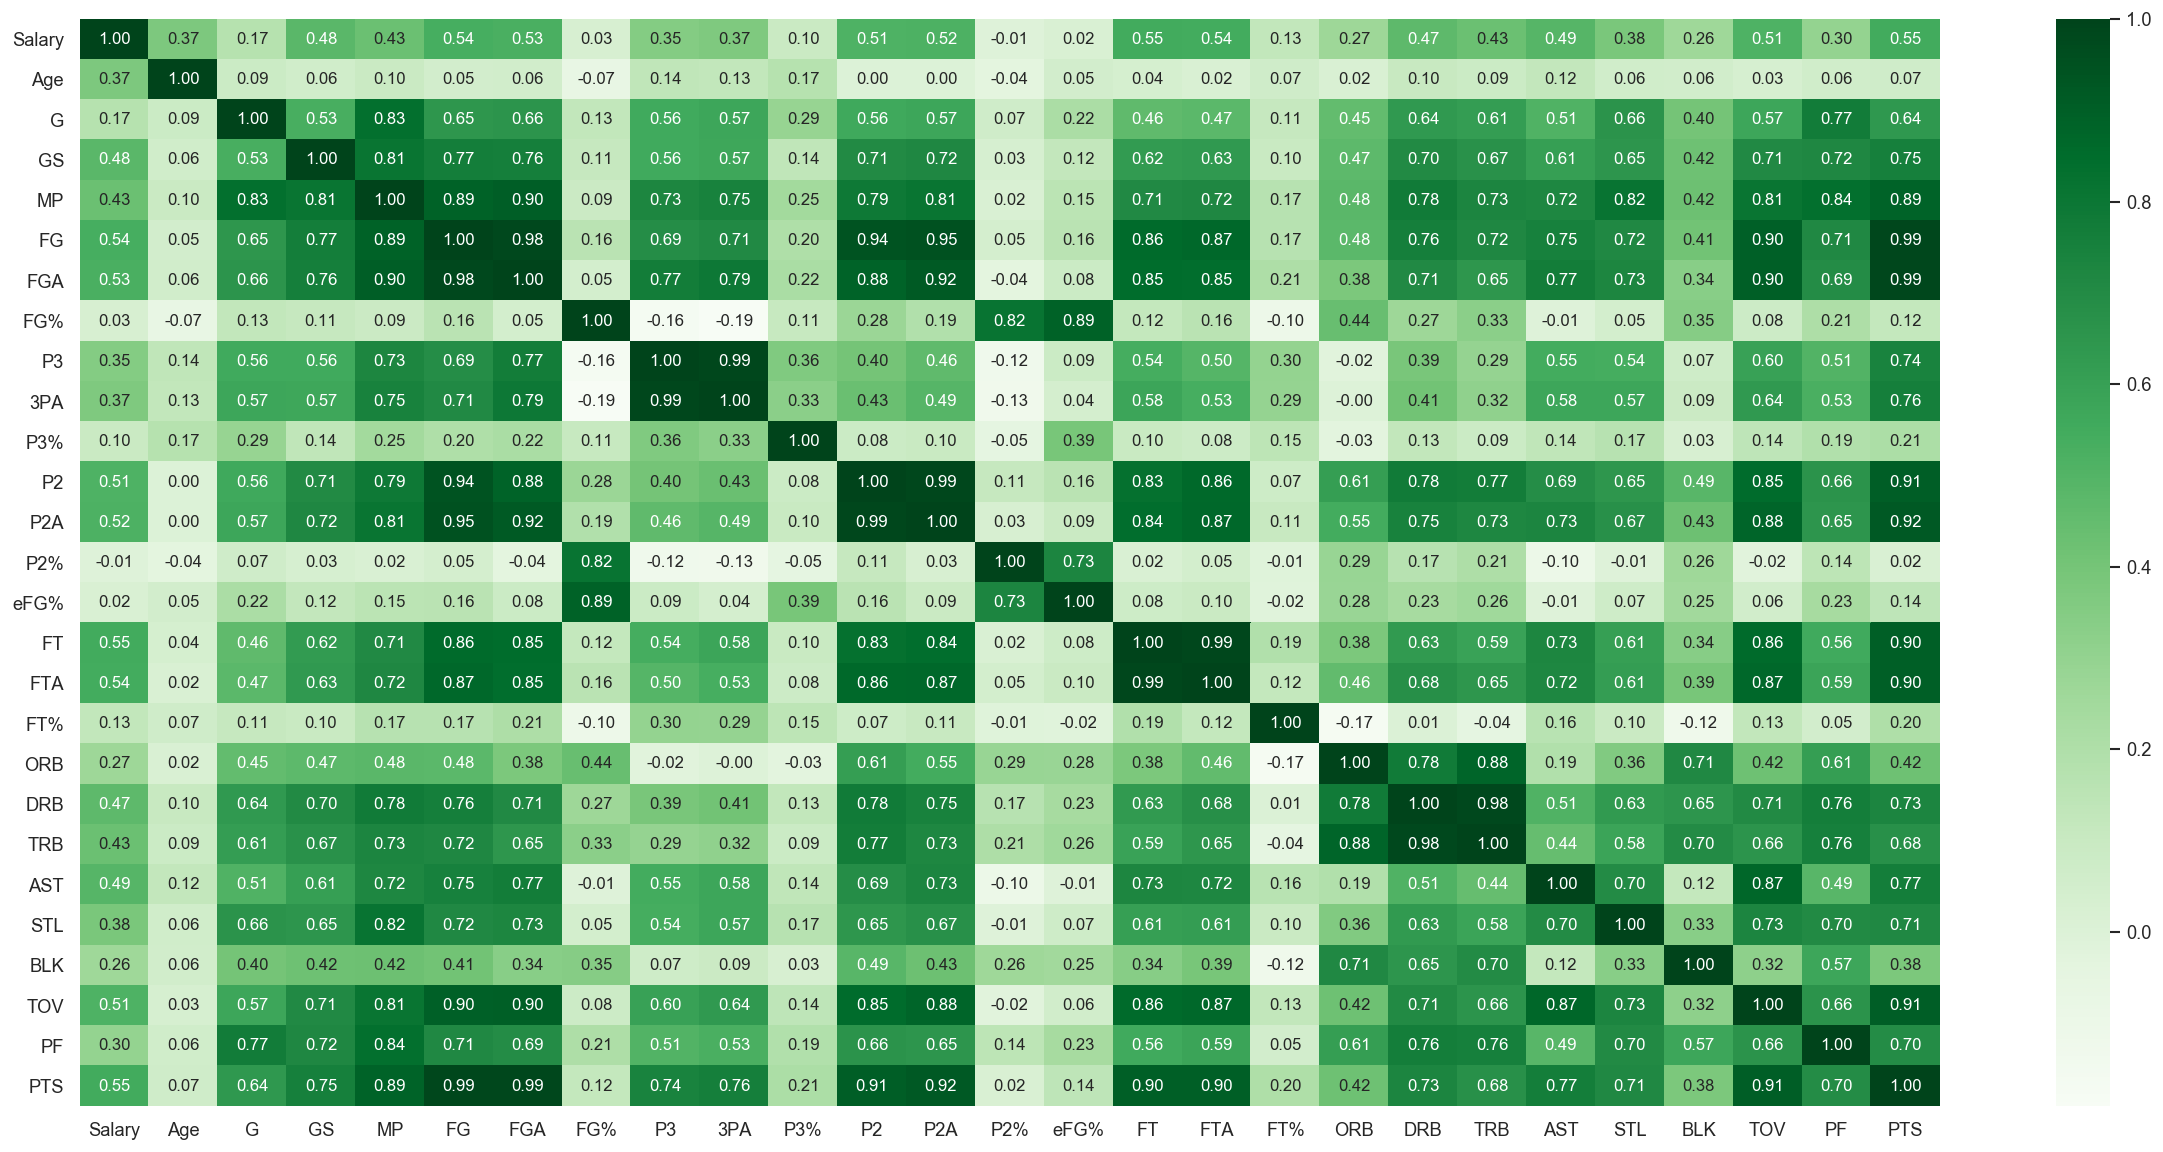

In [58]:
plt.figure(figsize=(25, 12))
sns.heatmap(clear_players_salary.corr(), annot=True, fmt=".2f", cmap=plt.cm.Greens)


> ### There are many features in the dataset. I select 12 features that have strong relevance to salary.

| Position | Position brief | 
| -- | -- | 
 |MP|Minutes Played |场均上场时间  
|FG| Field Goal   | 场均投篮命中
|FGA| Field Goal Attempts  |场均投篮出手次数
|2PA|2-Point Field Goal Attempts| 场均二分投篮出手次数 【2分球机会高于3分球】
|2P| 2-Point Field Goals  |场均二分投篮命中次数
|FT|	Free Throw   |罚球命中次数 
|FTA| Free Throws Attempted | 场均罚球次数
 |DRB| Defensive Rebounds  |场均防守篮板 【仅与 防守篮板有关。。。】
 |AST| Assists  |场均助攻 【助攻也很重要】
|TOV| turnovers |	失误次数 
| PTS| points  |场均得分【这个最重要。。。0.63最高了】

In [59]:
selected_df = clear_players_salary[['Salary','MP','FG','FGA','P2A','P2','FT','FTA','DRB','AST','TOV','PTS']]
print(selected_df.shape)
selected_df.head()

(385, 12)


,Salary,MP,FG,FGA,P2A,P2,FT,FTA,DRB,AST,TOV,PTS
0,19.863636,1914.0,314.0,726.0,500.0,246.0,137.0,203.0,338.0,215.0,94.0,833.0
1,2.329200,1368.0,202.0,496.0,293.0,122.0,62.0,72.0,111.0,193.0,75.0,546.0
3,1.618520,756.0,100.0,220.0,115.0,61.0,48.0,62.0,76.0,35.0,36.0,287.0
5,1.000000,293.0,30.0,75.0,28.0,16.0,9.0,13.0,28.0,14.0,7.0,83.0
6,28.000000,1848.0,289.0,654.0,390.0,200.0,55.0,73.0,320.0,244.0,65.0,722.0


> ### We could get information from the figure that a single parameter has little effect on salary. Free Throw (FT) and points(PTS) are the highest correlation with the salary in all Features.

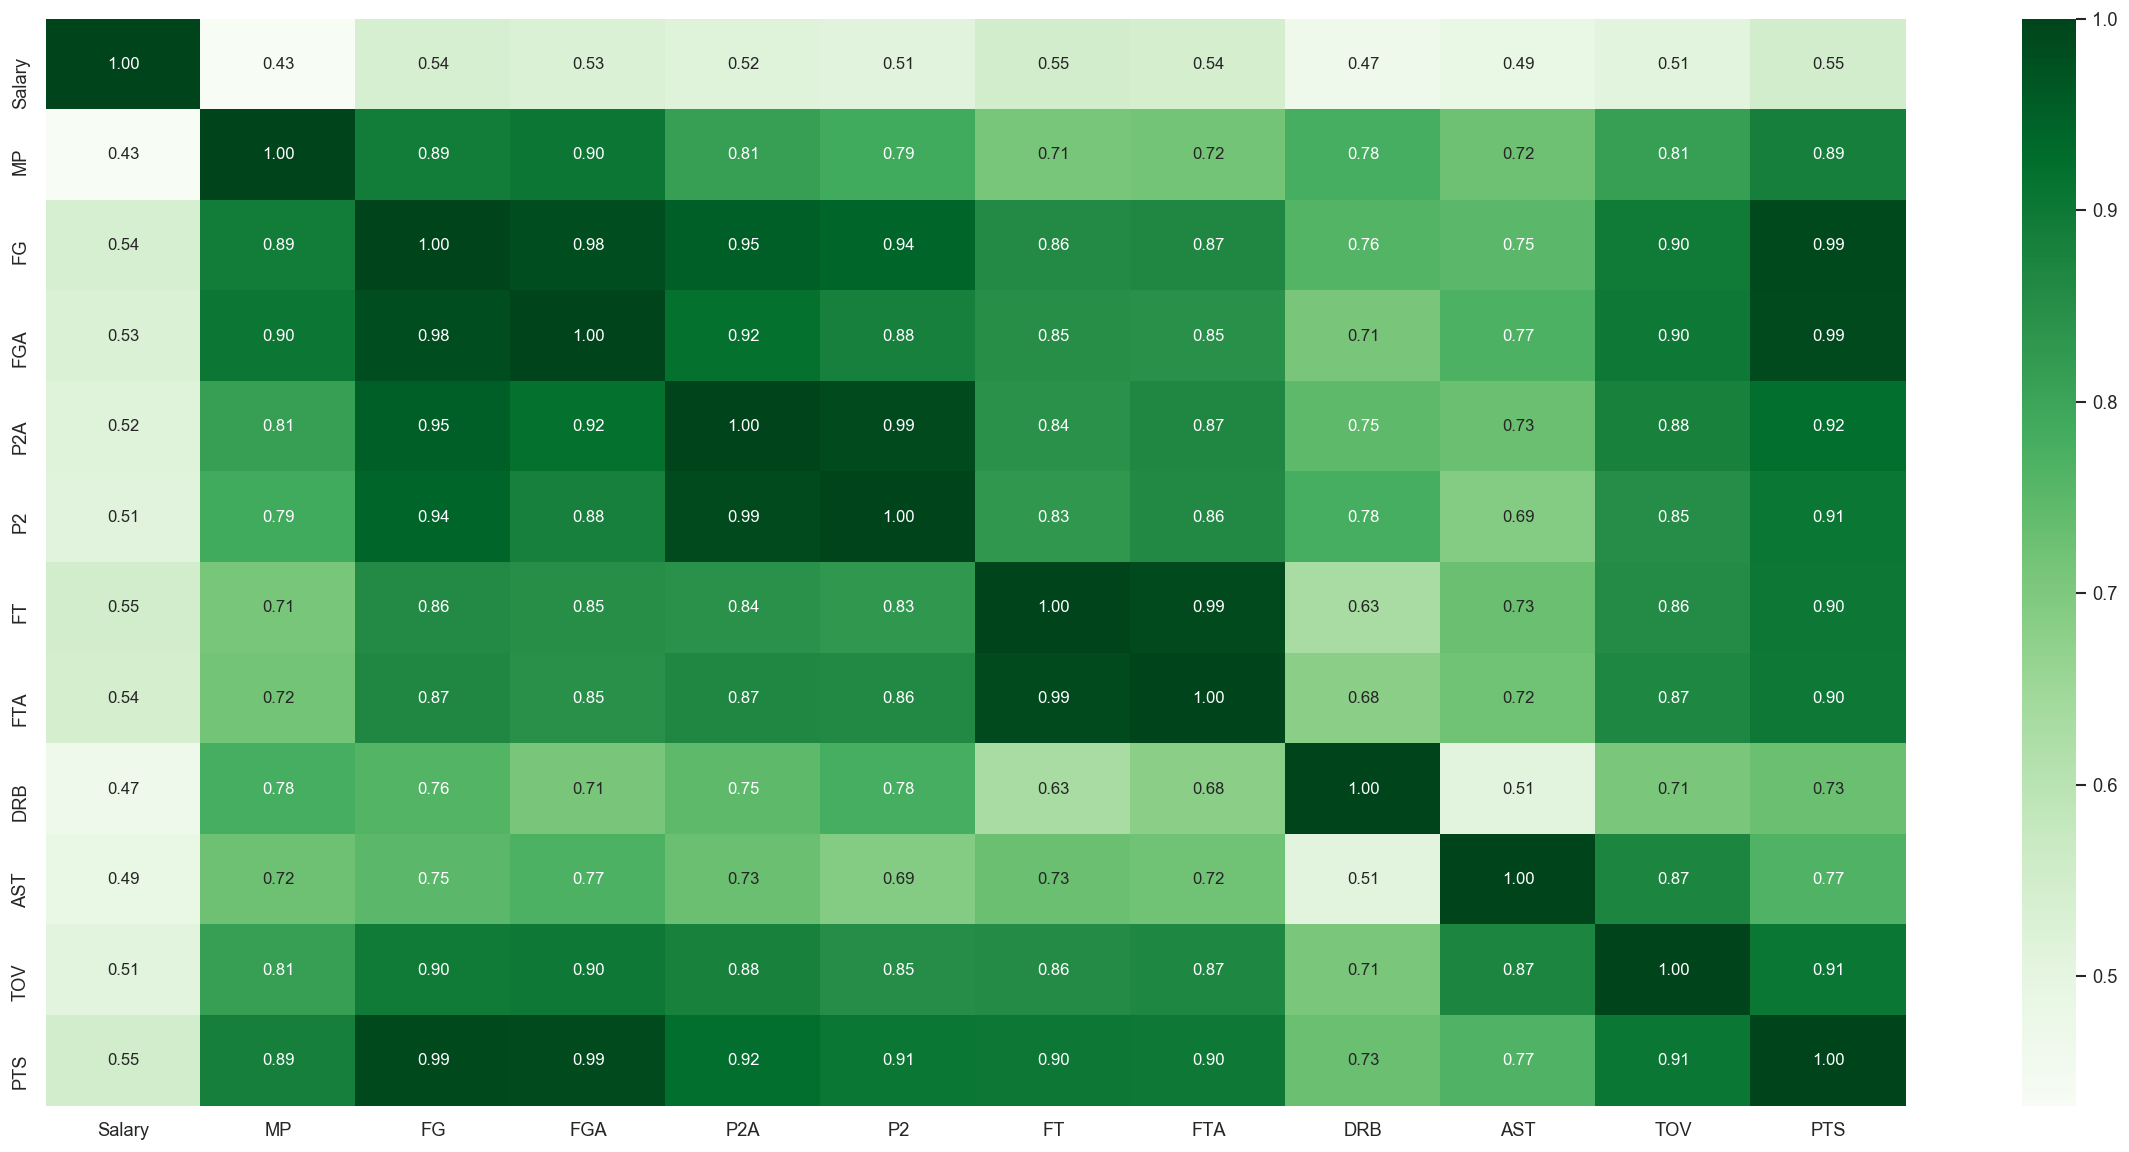

In [60]:
plt.figure(figsize=(25, 12))
sns.heatmap(selected_df.corr(), annot=True, fmt=".2f", cmap=plt.cm.Greens)

> ### The matrix scatters chart shows the relationship between data more intuitive. However, It is quite hard to find the relevance between salary with others' features.

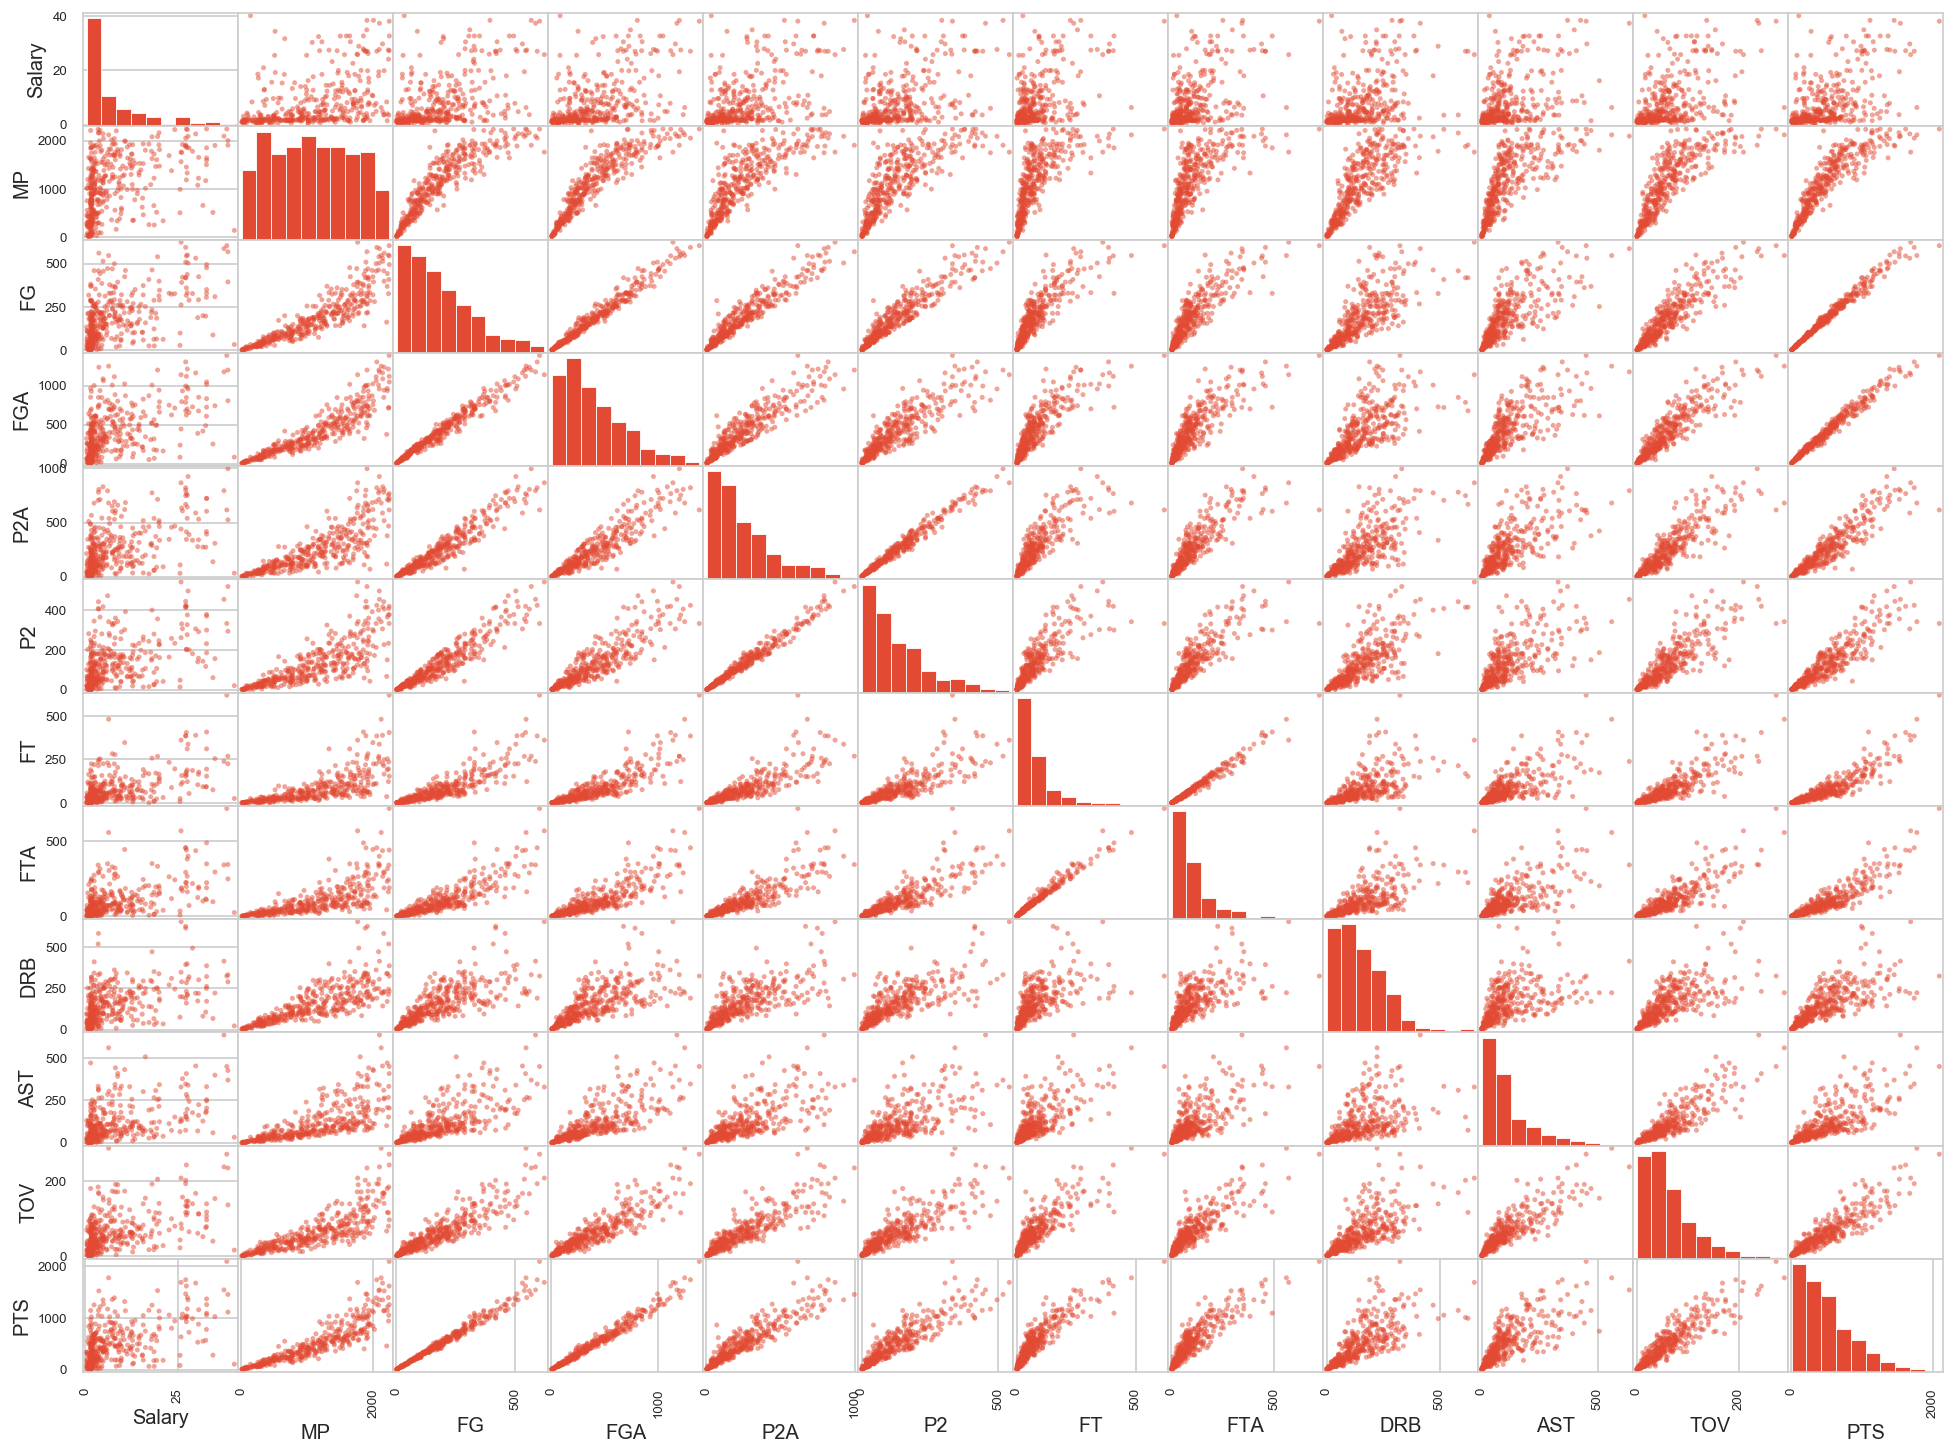

In [66]:
scatter_mat=pd.plotting.scatter_matrix(selected_df, figsize=(20, 15), diagonal='hist')

In [62]:
selected_df.cov()


,Salary,MP,FG,FGA,P2A,P2,FT,FTA,DRB,AST,TOV,PTS
Salary,81.446723,2401.059661,672.538357,1407.377333,963.704623,510.049593,422.858182,514.355354,463.501071,472.845466,232.062368,1930.423659
MP,2401.059661,379125.396943,76196.158597,164418.038494,103179.271652,53349.368797,37168.480445,46161.135599,52897.572477,47676.435741,25121.470948,212407.587439
FG,672.538357,76196.158597,19235.631602,40369.137263,27298.179911,14359.290341,10124.025142,12573.320556,11635.396983,11131.767620,6253.955188,53471.629606
FGA,1407.377333,164418.038494,40369.137263,87474.926231,56180.107813,28764.343561,21354.748011,26161.567424,23066.601089,24379.380919,13374.408617,113697.816241
P2A,963.704623,103179.271652,27298.179911,56180.107813,42626.649851,22429.427604,14815.475521,18708.419866,16997.309524,16158.131324,9120.402902,74280.587649
P2,510.049593,53349.368797,14359.290341,28764.343561,22429.427604,12092.028314,7766.286884,9916.576326,9437.698390,8144.428977,4715.513258,38752.129593
FT,422.858182,37168.480445,10124.025142,21354.748011,14815.475521,7766.286884,7221.443277,8788.694650,5926.432055,6642.574574,3663.407434,29827.231818
FTA,514.355354,46161.135599,12573.320556,26161.567424,18708.419866,9916.576326,8788.694650,10943.422524,7856.582927,8088.029627,4566.718175,36592.079992
DRB,463.501071,52897.572477,11635.396983,23066.601089,16997.309524,9437.698390,5926.432055,7856.582927,12162.100514,6016.357785,3908.664096,31394.924614
AST,472.845466,47676.435741,11131.767620,24379.380919,16158.131324,8144.428977,6642.574574,8088.029627,6016.357785,11471.405100,4698.614719,31893.448458


****

>### A single feature does not determine player salary. Multiple characteristics should determine player salary.

### Save the dataset for modeling.

In [63]:
selected_df.to_csv("fmanual_feature_Select_players_salary.csv.gz", compression='gzip')